In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell
using ArraysOfArrays
using SummationByPartsOperators

nthreads = 2


## 2D PIC Escheleton 

Here we run the 2D version of PIC. 

In [2]:
include("aux_functions/aux_functions.jl")
include("aux_functions/inidat_aux_functions.jl")


f_x

### Initial Distribution

## Initial data configurations (Particles first)

In [3]:
## initial data configurations

trys = false
thermal = false
#trys = true
thermal = true



true

In [4]:
if trys 
    run_name = "try_"
    data_name = "par_dis_norel_thermal_"
    J = (100,100)
    Box = (0.0, 2.0, 0.0, 1.0)
    nm = [1,1]
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    run_name = run_name * "Box_$(Box[2]-Box[1])x$(Box[4]-Box[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]_"
elseif thermal
    run_name = "thermal_norel_"
    data_name = "par_dis_norel_thermal_"
    J = (100,100)
    Box = (0.0, 1.0, 0.0, 1.0)
    nm = [1,1]
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    run_name = run_name * "Box_$(Box[2]-Box[1])x$(Box[4]-Box[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]_"
end

D = length(J)
order = 5

# For Landau perturbations
exp_alpha = 8 #8 for not perturbation
α = 10.0^(-exp_alpha)

# Particle numbers
N_exp = 5 #6
N = 10^(N_exp)

# Temperature
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(exp_alpha)_N$(N_exp)_Th$(exp_Theta)"

# Evolution parameters
exp_t = 1 #2
t = 0.0
t_i = 0.0
t_f = 10.0^(exp_t)
M = 1001 #16001# 4001 # 81 # 2001 # time steps 
M_g = 101 #8001 #400 + 1 #number of outputs, starting from the initial data
dx = differentials(Box,J)
@show dx_max = maximum(dx)
@show dt = (t_f-t_i)/(M-1)


# for plotting and other things
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])



@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, J, Box, order)
@show pars_f = (θ,)
par_init = (α, nm)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "tf_$(convert(Int,t_f))_N$(N_exp)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)
println(data_name)


data_name = data_name * "alp$(exp_alpha)_N$(N_exp)_Th$(exp_Theta)" = "par_dis_norel_thermal_nm_[1,1]_alp8_N5_Th3"
dx_max = maximum(dx) = 

0.01
dt = (t_f - t_i) / (M - 1) = 0.01
par_evolv = (t_i, t_f, M, M_g, dt) = 

(0.0, 10.0, 1001, 101, 0.01)


par_grid = (N, J, Box, order) = (100000, (100, 100), (0.0, 1.0, 0.0, 1.0), 5)
pars_f = (θ,) = (0.001,)
t_f = 10.0, M = 1001, dt = 0.01, exp_Theta = 3
thermal_norel_Box_1.0x1.0_J_100x100_nm_[1,1]_tf_10_N5_M1001_o5_Th3_alp8
par_dis_norel_thermal_nm_[1,1]_alp8_N5_Th3


In [5]:
par_dis, run_name, pars, par_f_x, Box_x, par_f_p, Box_p = retrieve_initial_data_D("Initial_Distributions/" * data_name * ".jld2")
#@show data_name_from_inidat, pars, par_f_x, Box_x, par_f_p, Box_p

([0.6247512065946293, 0.16941425561771473, 0.0011570603547534641, 0.013052489504106674, 0.5579024218734812, 0.5493278377269545, 0.02406221516041407, 0.00786341663023582, 0.14990011644641743, 0.6452159344413075  …  -0.0001918424985661582, 0.0022643873216561528, 0.12346104058401852, 0.614942178051615, 0.0014473728233468652, -0.029761852165804042, 0.1482598486823723, 0.7657924251888956, 0.004963653183085948, 0.001303598821366908], "par_dis_norel_thermal_nm_[1,1]_alp8_N5_Th3", (100000,), (1.0e-8, [1, 1], (0.0, 1.0, 0.0, 1.0)), (0.0, 1.0, 0.0, 1.0), (0.001, 2), (-0.14177446878757827, 0.14177446878757827, -0.14177446878757827, 0.14177446878757827))

### Check Density

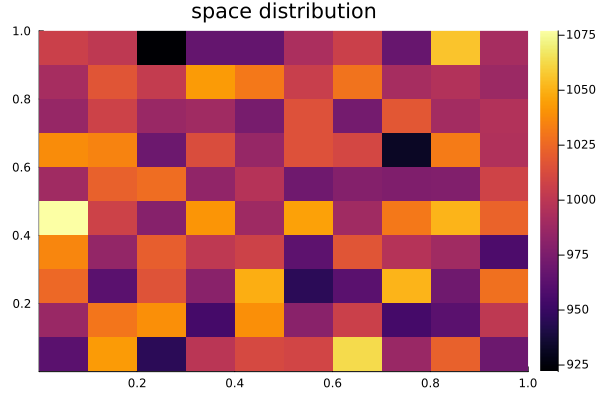

In [11]:
plot(histogram2d(par_dis[1:2D:end],par_dis[2:2D:end], title="space distribution" ))

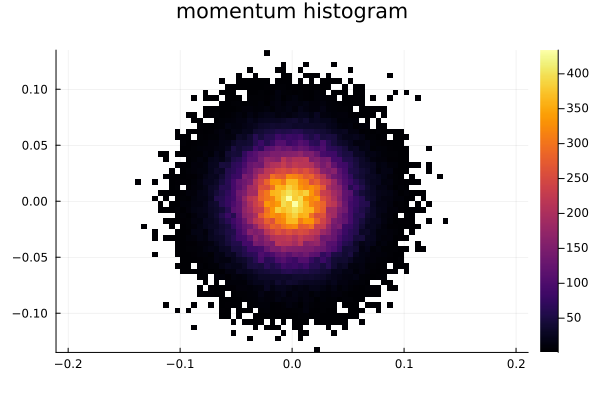

In [12]:
plot(histogram2d(par_dis[3:4:end],par_dis[4:4:end] )
,aspectratio=1
,title = "momentum histogram"
)

### Check Temperature

In [13]:
T = get_temperature_rel_D(par_dis,N,D)

0.0010004024556425938

In [6]:
par_grid = (N, Box_x, J, 5)
n = zeros(J)

get_density_2D!(par_dis, n, par_grid, 0.0)


100×100 Matrix{Float64}:
 9.91078e-5   0.00011352   8.62566e-5  …  0.000108448  0.000102303
 8.80948e-5   9.55478e-5   8.97442e-5     0.000107187  9.26546e-5
 9.19486e-5   8.6554e-5    9.48151e-5     0.000105974  8.92062e-5
 0.000111107  9.84646e-5   9.62758e-5     9.34848e-5   9.65525e-5
 0.000109872  9.4298e-5    8.79126e-5     9.19322e-5   0.000103586
 0.000102518  9.31518e-5   9.80142e-5  …  0.000106089  0.000112157
 0.00011122   9.35528e-5   9.70809e-5     0.000132619  0.000118429
 0.000107306  9.91376e-5   9.39957e-5     0.000123638  0.00010625
 9.12041e-5   0.000101867  9.83232e-5     8.89155e-5   9.14758e-5
 7.85614e-5   8.26363e-5   8.20118e-5     0.000106202  9.65178e-5
 ⋮                                     ⋱               
 8.9849e-5    8.08817e-5   8.53797e-5     8.79822e-5   8.48359e-5
 0.000100133  8.18931e-5   8.69185e-5     0.000115202  0.000113607
 0.000115615  0.000106131  9.46627e-5     0.000122173  0.000125224
 0.000114543  0.000104608  9.37087e-5     9.84126e-5   

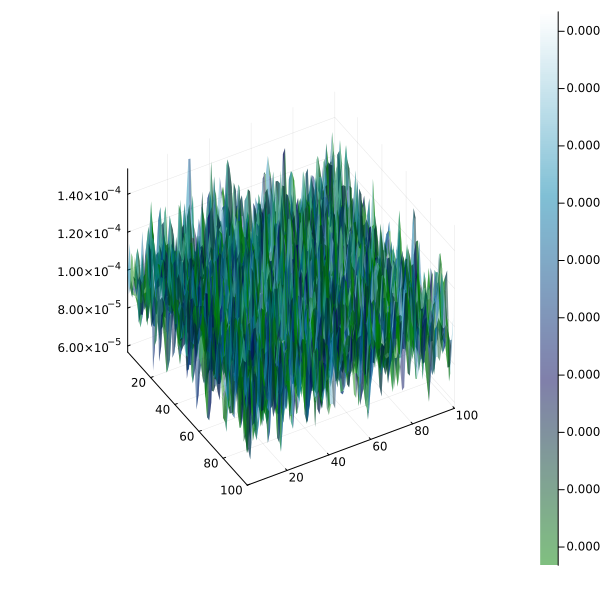

In [15]:


plot_matrix(n)

In [ ]:
#plot(n[:,5])

### Check Normalization

In [7]:
sum(n)

1.0

### Check Current

In [8]:
par_grid = (N, J, Box, 5)
S = [0.0::Float64 for l in 1:2, i in 1:J[1], j in 1:J[2]]
TS = zeros(Float64,(2,J...,nthreads()))

par_current_threads_S = (par_grid, TS)

get_current_threads_2D!(par_dis, S, par_current_threads_S)
S[1,3,4]

6.764406567626353e-7

In [ ]:
surface(y_p,x_p, S[1,:,:])

## Electric and Magnetic initial data

In [9]:
# We prescrive a constant magnetic field and the E is just a solution from Poisson's equations. 

B0 = 1.0 #initial magnetic field

B = [B0 for i in 1:J[1], j in 1:J[2]]

run_name = run_name * "B0_$(convert(Int,B0))_"

"par_dis_norel_thermal_nm_[1,1]_alp8_N5_Th3B0_1_"

In [10]:
E = Array{Float64,3}(undef,(2,J...))
ρ = n.-1.0/prod(J)
@show sum(ρ)
get_E!(E,ρ,Box);

sum(ρ) = 1.6046192152785466e-17


In [ ]:
surface(y_p,x_p, E[2,:,:])

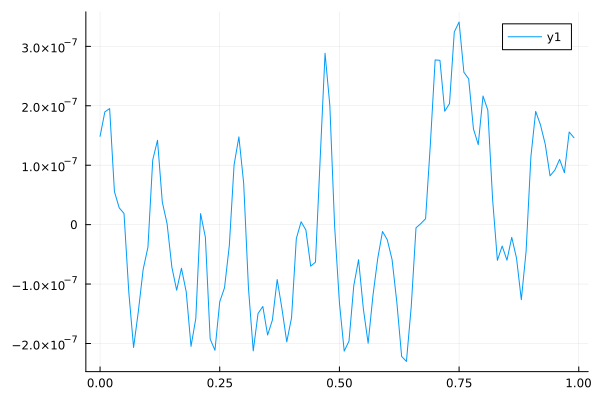

In [11]:
plot(x_p, E[1,:,50])

In [12]:
average_outputs = false # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
#phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.
full_outputs = true

true

We build the initial data:

In [13]:
u = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E and B

du = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E

u[1:4N] = par_dis 

Fu = view(u,4N+1:4N+3*prod(J))

F = reshape(Fu,3,J...)

#F = view(u[4N+1:end],3,J...)
F[1:2,:,:] = E
F[3,:,:] = B;

#u
#F[3,:,:]

100×100 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮              ⋱            ⋮                   
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

In [16]:
u[4N+2*prod(J)+1:end]
#u[4N+1:end-prod(J)]

10000-element Vector{Float64}:
  1.0
 -2.214559140521256e-8
 -2.4042061940464585e-7
  1.0
 -8.64744929688834e-8
 -2.1328247228796628e-7
  1.0
 -2.6560292795173128e-8
 -2.0108194896905924e-7
  1.0
  ⋮
  3.27219017413696e-8
  2.9192598574086826e-7
  1.0
  1.995319459499323e-8
  3.5340806520315244e-7
  1.0
 -5.99663583579232e-8
  3.371899079710969e-7
  1.0

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

### What follows are characterizations of the initial data properties.

In [15]:

Coordinate_test(u,Box)

#println("n_total = $(sum(n .- 1.0))")
#println("v_total = $(sum(u[N+1:2N]))")
#println("E_total = $(sum(E_i))")

#println("S_total = $(sum(S))")

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [16]:
if nthreads() > 1
TS = zeros(Float64, (2,J...,nthreads()))
p_RHS_D = (N, J, Box, order, n, S, du, get_density_2D!, get_current_threads_2D!, Interpolate_EBv_1, TS, Dx, Dy) ;
else
p_RHS_D = (N, J, Box, order, n, S, du, get_density_2D!, get_current_rel_2D!, Interpolate_EBv_1, Dx, Dy) ;
end


(100000, (100, 100), (0.0, 1.0, 0.0, 1.0), 5, [9.910777380201271e-5 0.00011352021570615571 … 0.00010844760284407619 0.00010230316904224945; 8.809481177704595e-5 9.554780412404223e-5 … 0.00010718711767428828 9.265459087500417e-5; … ; 9.406248629811504e-5 7.47673252097843e-5 … 8.936578599843269e-5 0.0001035871956332398; 0.00010963598401110314 9.37848639580357e-5 … 9.347213737719983e-5 0.00011653384854641414], [-2.0194383107215195e-7 -2.643686661202904e-7 … -2.741796680041341e-7 -1.5853077182810117e-7; 4.297495480441838e-7 4.0855529522764797e-7 … 9.28562631628176e-8 2.3527716729199973e-7;;; 7.208657348446063e-7 3.2580621066863504e-8 … -9.145252560145388e-8 7.951573045790231e-7; 7.981095100704061e-7 7.405660076238826e-7 … 5.762176719088114e-8 3.4112875152399285e-7;;; 7.276540838279668e-7 2.5434505055469105e-7 … 9.248363881153809e-8 6.561843888806968e-7; -4.622246379329505e-8 1.5212778123840332e-7 … 1.249673316808304e-7 -3.02122501756142e-7;;; … ;;; 4.0873683922754647e-7 4.0192741969598983e

In [17]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end


# up to here!

In [18]:
include("aux_functions/aux_functions.jl")
for k in 2:M
  RK4_Step!(RHS_D,u,t,dt,p_RHS_D)
  global u = [make_periodic!(u[1:4N],Box_x); u[2N+1:end]]
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $(Energy_Ks + Energy_Es)")

    if animation
      par[j,:] = u[1:2N]
    end
  end
end

In [ ]:
#@bell sleep(3)
E_f = zeros(J)
#ϕ_f = zeros(J)
#n_f = zeros(J) #charge density
if Poisson
    get_density!(u, n, par_grid, 0.0)
    get_ϕ!(ϕ, n .- 1., κ)
    get_E_from_ϕ!(ϕ,E_f,dx)
end
if E_direct
    get_density!(u, n, par_grid, 0.5)
    get_E_direct!(E_f,-n .+ 1.0,par_grid)
end

plot(E_i, label="E_i")
plot!(E_f, label="E_f")
plot!(u[2N+1:end], ls=:dash, label="Dynamical E_f")
png("Images/" * run_name * "Constraint_preservation.png")

Saving the results

In [ ]:
if remote_server
    exit() #if running as script
end

In [ ]:
rfft(E_i)[nm+1]

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |
